* 참조 깃헙
    * https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/07_Transfer_Learning/0_Pretrained_Basic/Transfer_Learning.ipynb
    * 모델 하나로 만들자.
    * 01_pretrainedVGG_media_v4
* MediaClassifier_a_VGG
    * 다른 네트워크의 base 가 되도록 만들기

## 1. Settings
### 1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [2]:
batch_size= 16 #64  #1
learning_rate = 0.0001
epoch = 50

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2. Data Loader
### 트레이닝 데이터

In [3]:
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([      
            # ①(512)③②RCrop  <-- Best !!
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

2895


/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### 고정된 데이터 셋

In [4]:
# 2. Dev data
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


# 3. Test data
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d," %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 4
['oil', 'pastel', 'pencil', 'water']
{'water': 3, 'pastel': 1, 'oil': 0, 'pencil': 2}
2895
Training: 2895, Dev: 620, Test: 621,


## 3. Model
### 1) Pretrained VGG Model

In [5]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#     print("yhk[%d]" %cnt),
#     print(i)
#     cnt = cnt+1

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [6]:
base_dim = 64
fsize = imgsize/32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [7]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True
    

# fc_layer = MyFullyConn().cuda()
# cnt = 0
# for param in fc_layer.parameters():
#     print("[%d]" %cnt),
#     print(param.requires_grad)
#     cnt = cnt+1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [8]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [9]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5. Train

In [10]:
# import utils

# total_time = 0
# disp_step = 10

# # 재시작하지 않는 다면
# for i in range(2):
#     print("%d.." %i),
#     for img,label in train_batch:
#         img = Variable(img).cuda()
#         label = Variable(label).cuda()

#         optimizer.zero_grad()
#         output = model(img)
#         print "output size:", output.size()
#         print "label size:", label.size()
#         loss = loss_func(output,label)

In [11]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    #netname = './nets/media_vgg19_fixed.pkl'
    #netname = './nets/media_vgg19_RCrop_fixed.pkl'
    netname = './nets/media_vgg19_50.pkl'
    model = torch.load(netname)
else:   
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/media_vgg19'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 20.03, dev: 17.74, test: 21.74
0..

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 
[0/50] loss: 1.187,  Correct of train: 67.56, dev: 69.35, test: 68.60,  time: 36.84 sec..
1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 
[10/50] loss: 0.835,  Correct of train: 77.96, dev: 75.00, test: 76.17,  time: 455.65 sec..
11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 
[20/50] loss: 0.505,  Correct of train: 82.83, dev: 77.90, test: 76.17,  time: 870.88 sec..
21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 
[30/50] loss: 0.527,  Correct of train: 85.11, dev: 78.87, test: 78.26,  time: 1280.66 sec..
31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 
[40/50] loss: 0.780,  Correct of train: 85.42, dev: 80.16, test: 78.26,  time: 1688.65 sec..
41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 
[49/50] loss: 0.261,  Correct of train: 87.08, dev: 79.68, test: 77.46,  time: 2054.75 sec..
Total time: 2054.75 sec


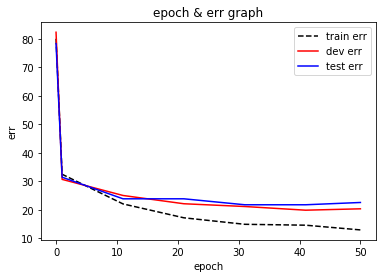

In [12]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


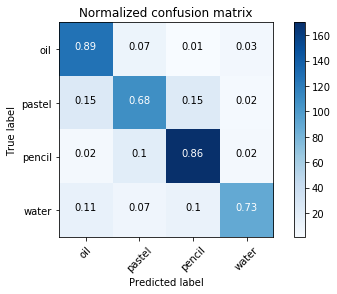

Confusion matrix, without normalization


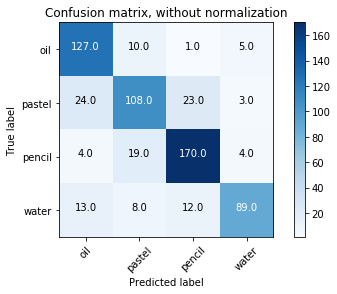

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.91 |	 0.76 |	 0.89 |	 0.82
 pastel: 0.82 |	 0.74 |	 0.68 |	 0.71
 pencil: 0.85 |	 0.83 |	 0.86 |	 0.84
 water: 0.93 |	 0.88 |	 0.73 |	 0.80
*accuracy: 0.88, precision: 0.80, recall: 0.79, *f1 score: 0.79
[AP] oil: 0.88 pastel: 0.74 pencil: 0.92 water: 0.87 
[mAP] 0.853
[miAP] 0.930


(array([2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 3, 2, 1, 3, 1, 1, 0, 1, 0, 2, 2, 3,
        0, 2, 3, 0, 2, 2, 2, 1, 2, 3, 0, 1, 0, 3, 1, 1, 0, 0, 0, 0, 2, 0,
        2, 2, 0, 2, 0, 3, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 3, 0, 1, 3, 1, 2,
        1, 2, 2, 2, 3, 1, 1, 1, 2, 0, 1, 0, 2, 3, 2, 2, 3, 2, 1, 1, 2, 2,
        3, 3, 1, 2, 3, 0, 2, 1, 0, 3, 3, 2, 3, 1, 2, 2, 2, 3, 2, 1, 1, 2,
        2, 3, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1,
        1, 0, 0, 3, 2, 0, 2, 1, 1, 3, 2, 1, 3, 0, 0, 0, 1, 2, 2, 1, 2, 1,
        3, 0, 2, 3, 0, 1, 3, 1, 2, 2, 2, 0, 3, 0, 3, 3, 2, 3, 3, 0, 2, 2,
        2, 0, 3, 1, 0, 0, 0, 2, 1, 2, 1, 2, 1, 1, 3, 1, 0, 2, 3, 0, 3, 0,
        0, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 3, 2, 1, 2, 0, 2, 1, 1, 3, 2, 2,
        2, 2, 1, 2, 0, 0, 1, 3, 0, 1, 2, 2, 0, 2, 1, 0, 2, 3, 2, 3, 3, 2,
        0, 3, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 3, 0, 2, 2, 3,
        1, 1, 0, 0, 1, 0, 0, 3, 3, 3, 

In [13]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


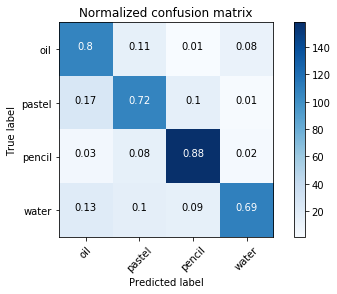

Confusion matrix, without normalization


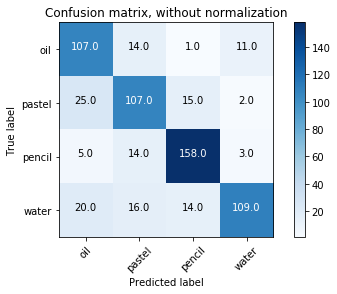

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.88 |	 0.68 |	 0.80 |	 0.74
 pastel: 0.80 |	 0.71 |	 0.72 |	 0.71
 pencil: 0.84 |	 0.84 |	 0.88 |	 0.86
 water: 0.89 |	 0.87 |	 0.69 |	 0.77
*accuracy: 0.85, precision: 0.78, recall: 0.77, *f1 score: 0.77
[AP] oil: 0.83 pastel: 0.79 pencil: 0.94 water: 0.90 
[mAP] 0.864
[miAP] 0.927


In [14]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: oil
 True predicted images/total oil category: 107 / 133
Predicted probability: [0.47450984 0.33602583 0.0055182  0.18394612]


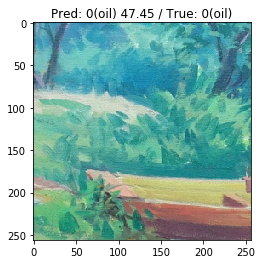

Predicted probability: [0.787895   0.13023931 0.01905716 0.06280852]


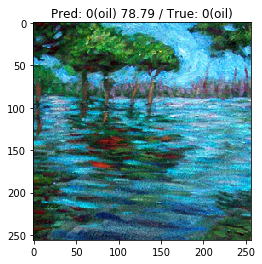

 False predicted images/total oil category: 26 / 133
Predicted probability: [0.26006866 0.5908849  0.05518107 0.09386535]


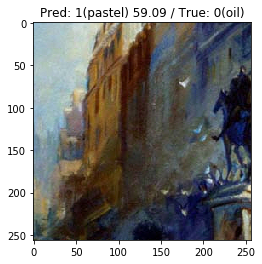

Predicted probability: [0.46931285 0.00271882 0.00738249 0.52058583]


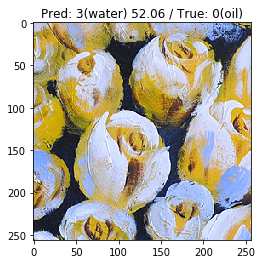

Category: pastel
 True predicted images/total pastel category: 107 / 149
Predicted probability: [0.35059324 0.6411342  0.00075385 0.00751869]


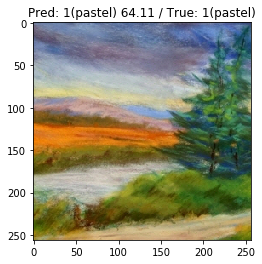

Predicted probability: [0.07637267 0.6531884  0.14815488 0.12228404]


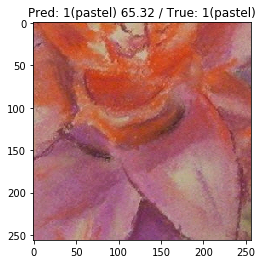

 False predicted images/total pastel category: 42 / 149
Predicted probability: [0.710221   0.12368666 0.08959635 0.07649599]


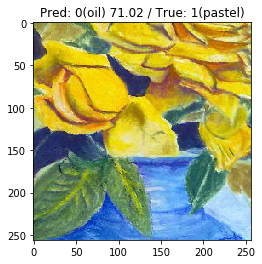

Predicted probability: [5.6337905e-01 4.2394397e-01 1.1543069e-04 1.2561569e-02]


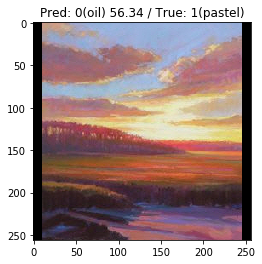

Category: pencil
 True predicted images/total pencil category: 158 / 180
Predicted probability: [2.2511261e-04 2.1711149e-04 9.9940342e-01 1.5433275e-04]


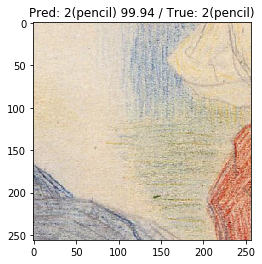

Predicted probability: [0.1206926  0.08919596 0.671688   0.11842339]


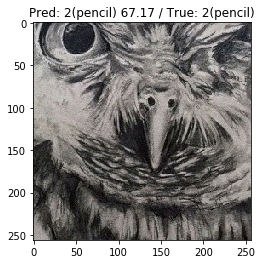

 False predicted images/total pencil category: 22 / 180
Predicted probability: [7.0927717e-04 7.2234809e-01 2.6465607e-01 1.2286562e-02]


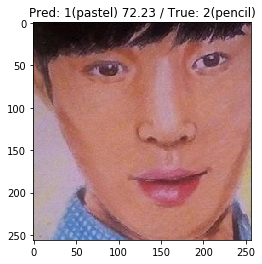

Predicted probability: [0.00253948 0.6786555  0.2396645  0.07914053]


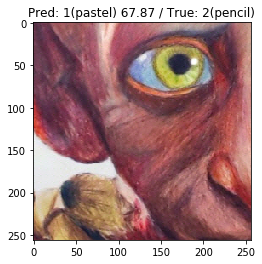

Category: water
 True predicted images/total water category: 109 / 159
Predicted probability: [0.2694792  0.03787198 0.05339371 0.6392551 ]


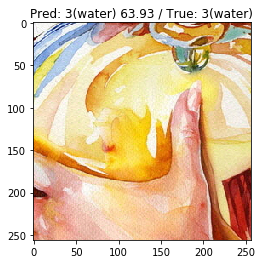

Predicted probability: [1.3144502e-01 4.4508546e-04 3.1482392e-05 8.6807841e-01]


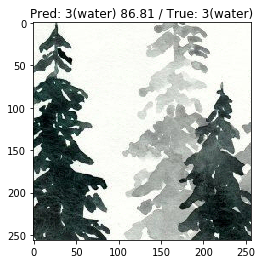

 False predicted images/total water category: 50 / 159
Predicted probability: [0.41321203 0.33512685 0.03308088 0.21858025]


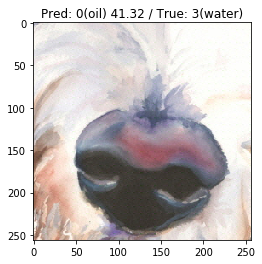

Predicted probability: [2.2242320e-04 1.6529503e-01 7.4904615e-01 8.5436374e-02]


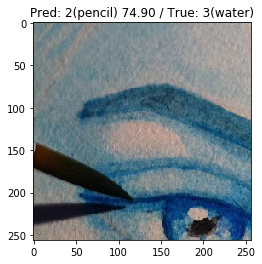

In [15]:
utils.VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=2)